# Business Problem

A fast food chain is planning to add a new product to its menu.

They are undecided about three possible marketing campaigns to promote this new product.

To determine which promotion has the greatest impact on sales, the new product is promoted in several randomly selected convenience stores.

With these promotions in different locations, the weekly sales of the new product are recorded for the first four weeks.

# Task
Evaluate the results of the A/B test and decide which marketing strategy works best.

# Variables
MarketID: Unique market id
MarketSize MarketSize
LocationID: Unique store location
AgeOfStore Age of Store
Promotion: Type of promotion tested
week One of the four weeks when promotions are managed
SalesInThousands Sales Amount


| Feature | Definition |
| --- | --- |
| MarketID | Unique market id |
| MarketSize | Market Size |
| LocationID | Unique store location |
| AgeOfStore | Age of Store |
| Promotion | Type of promotion tested |
| week | One of the four weeks when promotions are managed |
| SalesInThousands | Sales Amount |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# !pip install statsmodels
import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, f_oneway, kruskal

plt.style.use('fivethirtyeight')

# Section 1 - Data Understanding

In [2]:
df_ = pd.read_csv('data/wa_marketing_campaign.csv')
df = df_.copy()

In [3]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [5]:
# Sales statistics by week
df.groupby('week').agg({'SalesInThousands': ['count', 'mean', 'median']})

SalesInThousands                  
                count       mean median
week                                   
1                 137  53.790584  50.20
2                 137  53.386569  51.09
3                 137  53.474599  50.11
4                 137  53.213066  49.71

In [6]:
# Market tipine göre satış istatistikleri
df.groupby('MarketSize').agg({'SalesInThousands': ['count', 'mean', 'median']})

SalesInThousands                   
                      count       mean  median
MarketSize                                    
Large                   168  70.116726  75.020
Medium                  320  43.985344  44.590
Small                    60  57.409333  57.555

In [7]:
# Uygulanan promosyon tipine göre satış istatistikleri
df.groupby('Promotion').agg({'SalesInThousands': ['count', 'mean', 'median']})

SalesInThousands                   
                     count       mean  median
Promotion                                    
1                      172  58.099012  55.385
2                      188  47.329415  45.385
3                      188  55.364468  51.165

In [8]:
# Market ve Promosyon Tipi kırılımında satış istatistikleri
df.groupby(['MarketSize', 'Promotion']).agg({'SalesInThousands': ['count', 'mean', 'median']})

SalesInThousands                   
                                count       mean  median
MarketSize Promotion                                    
Large      1                       56  75.235893  72.835
           2                       64  60.322031  53.010
           3                       48  77.203958  82.345
Medium     1                       96  47.672604  47.425
           2                      108  39.114352  39.765
           3                      116  45.468879  46.295
Small      1                       20  60.162500  61.145
           2                       16  50.810625  51.600
           3                       24  59.514167  59.745

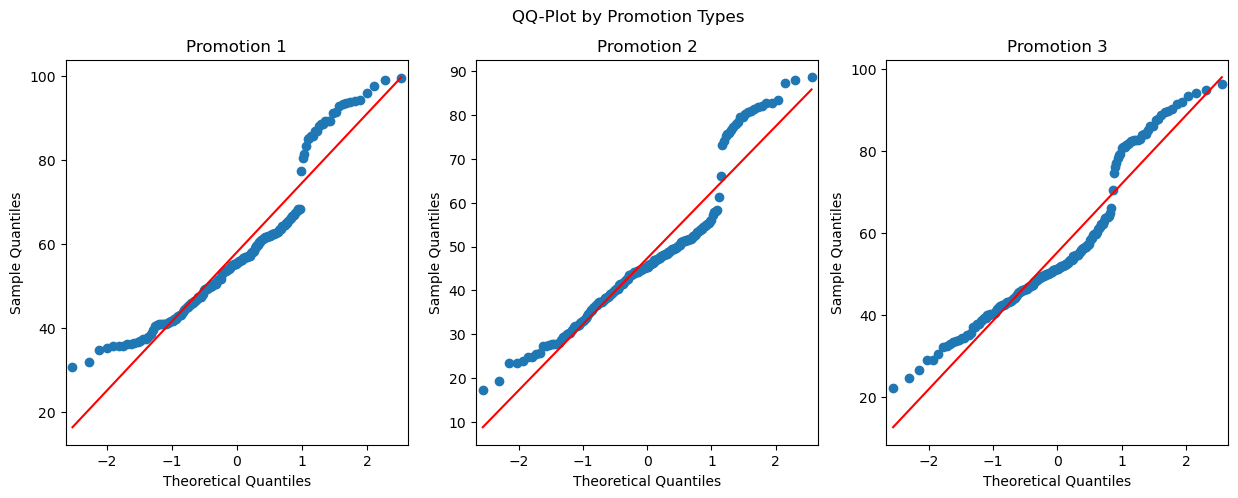

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

qqplot(np.array(df.loc[(df['Promotion'] ==1), 'SalesInThousands']), line='s', ax=axs[0])
qqplot(np.array(df.loc[(df['Promotion'] ==2), 'SalesInThousands']), line='s', ax=axs[1])
qqplot(np.array(df.loc[(df['Promotion'] ==3), 'SalesInThousands']), line='s', ax=axs[2])


axs[0].set_title("Promotion 1")
axs[1].set_title("Promotion 2")
axs[2].set_title("Promotion 3")

fig.suptitle(f"QQ-Plot by Promotion Types")

plt.show()

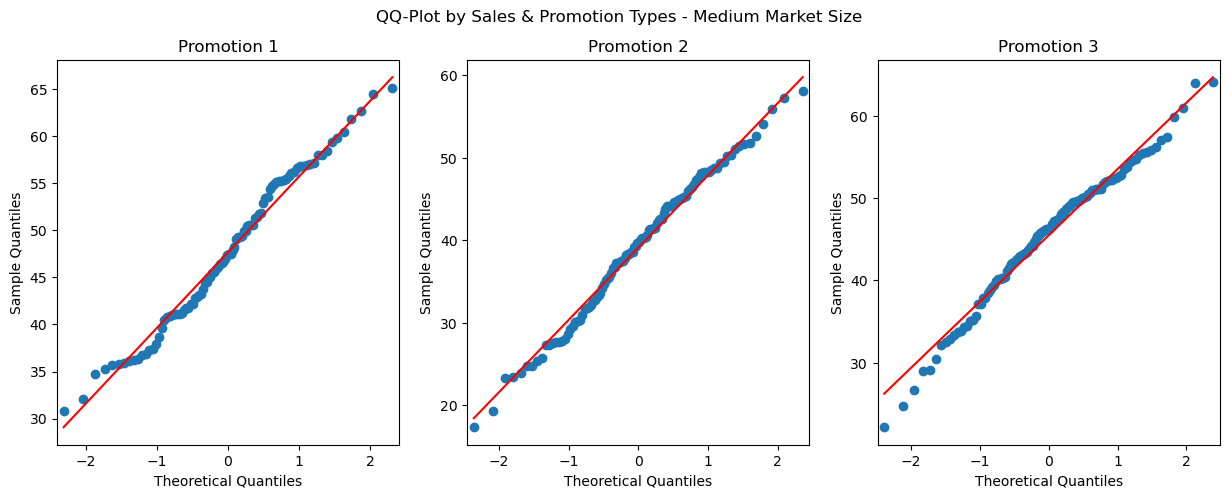

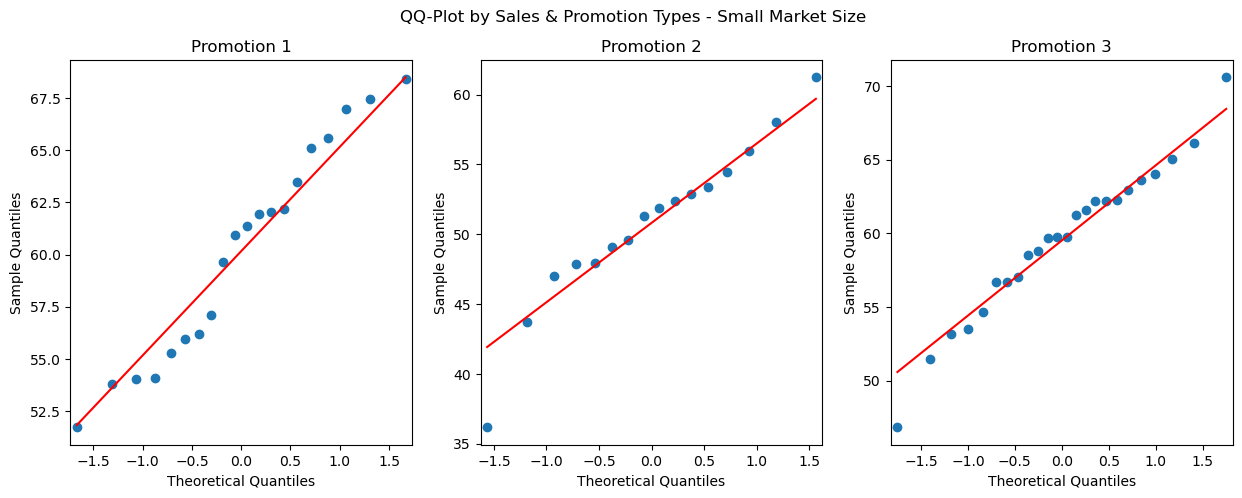

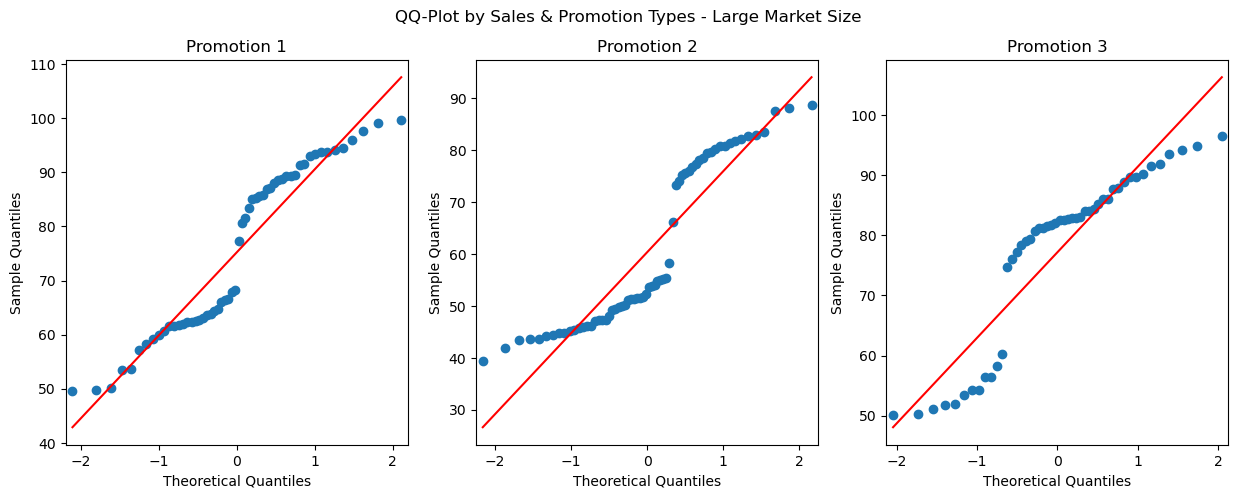

In [10]:
market_sizes = df['MarketSize'].unique()

for market_size in market_sizes:

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    qqplot(np.array(df.loc[(df['Promotion'] ==1) & (df['MarketSize'] == market_size), 'SalesInThousands']), line='s', ax=axs[0])
    qqplot(np.array(df.loc[(df['Promotion'] ==2) & (df['MarketSize'] == market_size), 'SalesInThousands']), line='s', ax=axs[1])
    qqplot(np.array(df.loc[(df['Promotion'] ==3) & (df['MarketSize'] == market_size), 'SalesInThousands']), line='s', ax=axs[2])
    

    axs[0].set_title("Promotion 1")
    axs[1].set_title("Promotion 2")
    axs[2].set_title("Promotion 3")
    
    fig.suptitle(f"QQ-Plot by Sales & Promotion Types - {market_size} Market Size")
    
    plt.show()

# Section II - ANOVA Hypothesis

### Step #1
**Define hypothesis**

- HO: m1 = m2 = m3 = m4 There is no difference between group averages.
- H1: m1 != m2 =m3 = m4 At least one group mean is different from other group means

### Step #2
**Assumption control**

- Assumption of normality
- Assumption of homogeneity of variance

---
- **One Way ANOVA** if assumption is fulfilled
- **Kruskal Wallis** if assumption is not fulfilled


### Step #2.1

### Assumption of Normality - Shapiro Wilk Test


In [12]:
for promotion in list(df["Promotion"].unique()):
    pvalue = shapiro(df.loc[df["Promotion"] == promotion, "SalesInThousands"])[1]
    print('Promotion:', promotion, 'p-value: %.4f' % pvalue)

Promotion: 3 p-value: 0.0000
Promotion: 2 p-value: 0.0000
Promotion: 1 p-value: 0.0000


According to the report

For 3 Promotions, H0 is rejected, i.e. the assumption of normality is not fulfilled.

**Non parametric** test should be performed, but let's check the homogeneity of variance.


### Step#2.2

### Assumption of Variance Homogeneity - Levene Test

In [15]:
test_stat, pvalue = levene(df.loc[df["Promotion"] == 1, "SalesInThousands"],
                           df.loc[df["Promotion"] == 2, "SalesInThousands"],
                           df.loc[df["Promotion"] == 3, "SalesInThousands"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1.2697, p-value = 0.2818


H0: Assumption of homogeneity of variance is satisfied.


### Step #3 

Hypothesis testing and p-value interpretation:

The assumption of normality is not fulfilled, while the assumption of homogeneity of variance is fulfilled. 

Therefore, Non-parametric test should be applied.

In [17]:
# Sales statistics according to the type of promotion applied
df.groupby('Promotion').agg({'SalesInThousands': ['mean', 'median']})

SalesInThousands        
                      mean  median
Promotion                         
1                58.099012  55.385
2                47.329415  45.385
3                55.364468  51.165

# Section III - ANOVA, Kruskal Wallis

### **Reminder:**

With a test of more than two groups, testing whether there is a difference between groups and testing whether there is a difference between the means of individual groups are different things.

Methods such as `ANOVA` and `Kruskal Wallis` take into consideration variability within and between groups.

### Step #1
### Nonparametric ANOVA Test - Kruskal Wallis

- HO: m1 = m2 = m3 = m4 There is no difference between group means.

- H1: m1 != m2 =m3 = m4 At least one group mean is different from other group means

In [18]:
kruskal(df.loc[df["Promotion"] == 1, "SalesInThousands"],
               df.loc[df["Promotion"] == 2, "SalesInThousands"],
               df.loc[df["Promotion"] == 3, "SalesInThousands"])

KruskalResult(statistic=53.29475169322799, pvalue=2.6741866266697816e-12)

According to report;
    
Since the pvalue is less than `0.05`, **H0 is rejected**, i.e. there is a significant difference between the groups.



### Step #2 
### Which Group Makes the Difference - Tukey Test


In [20]:
from statsmodels.stats.multicomp import MultiComparison
comparison = MultiComparison(df['SalesInThousands'], df['Promotion'])
tukey = comparison.tukeyhsd(0.05)
print(comparison.tukeyhsd(0.05))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


- There is a significant difference between 1 and 2 promotions.
- There is **no significant difference** between 1 and 3 promotions.
- There is a significant difference between 2 and 3 promotions.

In [21]:
df.groupby('Promotion').agg({'SalesInThousands': 'mean'})

,SalesInThousands
Promotion,
1,58.099012
2,47.329415
3,55.364468


### Step #3

**Recommendation:**

With the available data, we recommend promotion 1, but it would be useful to increase the number of data and measure it again.

It may also be useful to implement a hybrid campaign with 60% Promotion 1 and 40% Promotion 3.